In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

# Load MIND dataset
def load_mind_data():
    base_path = "../data/mind/MINDsmall_train"
    #base_path = "/full/path/to/MINDsmall_train"

    # Load news data
    news_df = pd.read_csv(f"{base_path}/news.tsv", sep='\t', header=None,
                         names=['news_id', 'category', 'subcategory', 'title', 
                               'abstract', 'url', 'title_entities', 'abstract_entities'])
    
    # Load behaviors
    behaviors_df = pd.read_csv(f"{base_path}/behaviors.tsv", sep='\t', header=None,
                              names=['impression_id', 'user_id', 'timestamp', 
                                    'history', 'impressions'])
    
    # Load entity embeddings
    entity_embeddings = {}
    with open(f"{base_path}/entity_embedding.vec", 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            entity_id = parts[0]
            embedding = [float(x) for x in parts[1:]]
            entity_embeddings[entity_id] = embedding
    
    return news_df, behaviors_df, entity_embeddings

# Initialize data
news_df, behaviors_df, entity_embeddings = load_mind_data()
print(f"Loaded {len(news_df)} news articles")
print(f"Loaded {len(behaviors_df)} user behaviors") 
print(f"Loaded {len(entity_embeddings)} entity embeddings")

Loaded 51282 news articles
Loaded 156965 user behaviors
Loaded 26904 entity embeddings


In [8]:
#Entity Extraction

def extract_entities_from_news(news_df):
    """Extract and process entities from news articles"""
    all_entities = {}
    entity_categories = defaultdict(set)
    entity_news_mapping = defaultdict(set)
    
    for idx, row in tqdm(news_df.iterrows(), total=len(news_df)):
        news_id = row['news_id']
        
        # Process title entities
        if pd.notna(row['title_entities']) and row['title_entities'] != '[]':
            try:
                title_entities = json.loads(row['title_entities'])
                for entity in title_entities:
                    entity_id = entity['WikidataId']
                    entity_label = entity['Label']
                    entity_type = entity['Type']
                    
                    all_entities[entity_id] = {
                        'label': entity_label,
                        'type': entity_type,
                        'confidence': entity.get('Confidence', 1.0)
                    }
                    entity_categories[entity_type].add(entity_id)
                    entity_news_mapping[entity_id].add(news_id)
            except:
                pass
        
        # Process abstract entities
        if pd.notna(row['abstract_entities']) and row['abstract_entities'] != '[]':
            try:
                abstract_entities = json.loads(row['abstract_entities'])
                for entity in abstract_entities:
                    entity_id = entity['WikidataId']
                    entity_label = entity['Label']
                    entity_type = entity['Type']
                    
                    all_entities[entity_id] = {
                        'label': entity_label,
                        'type': entity_type,
                        'confidence': entity.get('Confidence', 1.0)
                    }
                    entity_categories[entity_type].add(entity_id)
                    entity_news_mapping[entity_id].add(news_id)
            except:
                pass
    
    return all_entities, entity_categories, entity_news_mapping

# Extract entities
all_entities, entity_categories, entity_news_mapping = extract_entities_from_news(news_df)

print(f"Extracted {len(all_entities)} unique entities")
print(f"Entity types: {list(entity_categories.keys())}")
print(f"Top entity types by count:")
for etype, entities in sorted(entity_categories.items(), key=lambda x: len(x[1]), reverse=True)[:10]:
    print(f"  {etype}: {len(entities)} entities")

100%|██████████| 51282/51282 [00:05<00:00, 10098.60it/s]

Extracted 27759 unique entities
Entity types: ['P', 'C', 'G', 'O', 'M', 'J', 'V', 'W', 'F', 'U', 'N', 'S', 'E', 'L', 'B', 'H', 'Y', 'K', 'R', 'I', 'Q', 'A']
Top entity types by count:
  P: 6220 entities
  G: 4402 entities
  O: 3919 entities
  U: 3097 entities
  C: 2384 entities
  F: 1658 entities
  N: 1252 entities
  S: 1198 entities
  W: 1034 entities
  M: 716 entities


In [9]:
#KG Structure

def build_knowledge_graph(all_entities, entity_news_mapping, news_df):
    """Build NetworkX knowledge graph"""
    G = nx.Graph()
    
    # Add entity nodes
    for entity_id, entity_data in tqdm(all_entities.items(), desc="Adding entity nodes"):
        G.add_node(entity_id, 
                   node_type='entity',
                   label=entity_data['label'],
                   entity_type=entity_data['type'],
                   confidence=entity_data['confidence'])
    
    # Add news nodes
    for _, row in tqdm(news_df.iterrows(), desc="Adding news nodes"):
        G.add_node(row['news_id'],
                   node_type='news',
                   title=row['title'],
                   category=row['category'],
                   subcategory=row['subcategory'])
    
    # Add entity-news edges
    for entity_id, news_ids in tqdm(entity_news_mapping.items(), desc="Adding entity-news edges"):
        for news_id in news_ids:
            if G.has_node(entity_id) and G.has_node(news_id):
                G.add_edge(entity_id, news_id, edge_type='mentions')
    
    # Add entity-entity co-occurrence edges
    entity_pairs = defaultdict(int)
    for news_ids in tqdm(entity_news_mapping.values(), desc="Computing co-occurrences"):
        news_entities = [eid for eid, nids in entity_news_mapping.items() 
                        if len(nids.intersection(news_ids)) > 0]
        
        # Add edges between entities that co-occur in news
        for i, e1 in enumerate(news_entities):
            for e2 in news_entities[i+1:]:
                entity_pairs[(e1, e2)] += 1
    
    # Add co-occurrence edges (with weight threshold)
    min_cooccurrence = 2
    for (e1, e2), weight in tqdm(entity_pairs.items(), desc="Adding co-occurrence edges"):
        if weight >= min_cooccurrence:
            G.add_edge(e1, e2, edge_type='co_occurs', weight=weight)
    
    return G

# Build the knowledge graph
print("Building knowledge graph...")
KG = build_knowledge_graph(all_entities, entity_news_mapping, news_df)

print(f"Knowledge Graph Statistics:")
print(f"  Nodes: {KG.number_of_nodes()}")
print(f"  Edges: {KG.number_of_edges()}")
print(f"  Entity nodes: {sum(1 for n, d in KG.nodes(data=True) if d['node_type'] == 'entity')}")
print(f"  News nodes: {sum(1 for n, d in KG.nodes(data=True) if d['node_type'] == 'news')}")

Building knowledge graph...


Adding entity nodes: 100%|██████████| 27759/27759 [00:00<00:00, 258857.46it/s]
Adding news nodes: 51282it [00:04, 11122.72it/s]
Adding co-occurrence edges: 100%|██████████| 7676750/7676750 [00:08<00:00, 880950.61it/s] 


Knowledge Graph Statistics:
  Nodes: 79041
  Edges: 1631862
  Entity nodes: 27759
  News nodes: 51282


In [10]:
def add_user_interactions(KG, behaviors_df):
    """Add user nodes and interaction edges to knowledge graph"""
    
    # Add user nodes
    unique_users = behaviors_df['user_id'].unique()
    for user_id in tqdm(unique_users, desc="Adding user nodes"):
        KG.add_node(user_id, node_type='user')
    
    # Add user-news interaction edges
    for _, row in tqdm(behaviors_df.iterrows(), desc="Adding user interactions"):
        user_id = row['user_id']
        
        # Process clicked history
        if pd.notna(row['history']):
            clicked_news = row['history'].split()
            for news_id in clicked_news:
                if KG.has_node(news_id):
                    KG.add_edge(user_id, news_id, edge_type='clicked')
        
        # Process impressions
        if pd.notna(row['impressions']):
            impressions = row['impressions'].split()
            for impression in impressions:
                parts = impression.split('-')
                if len(parts) == 2:
                    news_id, clicked = parts
                    if KG.has_node(news_id):
                        if clicked == '1':
                            KG.add_edge(user_id, news_id, edge_type='clicked')
                        else:
                            KG.add_edge(user_id, news_id, edge_type='viewed')
    
    return KG

# Add user interactions
print("Adding user interaction layer...")
KG = add_user_interactions(KG, behaviors_df)

print(f"Updated Knowledge Graph Statistics:")
print(f"  Total nodes: {KG.number_of_nodes()}")
print(f"  Total edges: {KG.number_of_edges()}")
print(f"  User nodes: {sum(1 for n, d in KG.nodes(data=True) if d['node_type'] == 'user')}")

Adding user interaction layer...


Adding user nodes: 100%|██████████| 50000/50000 [00:00<00:00, 217693.00it/s]
Adding user interactions: 156965it [01:10, 2220.63it/s]


Updated Knowledge Graph Statistics:
  Total nodes: 129041
  Total edges: 7526846
  User nodes: 50000


 Starting  KG analysis...
 Quick Graph Summary
Total Nodes: 129,041
Total Edges: 7,526,846

Sample Nodes:
  Q80976: entity - Prince Philip, Duke of Edinbur
  Q43274: entity - Charles, Prince of Wales
  Q9682: entity - Elizabeth II
  Q193583: entity - Adipose tissue
  Q212: entity - Ukraine
 Running fast KG analysis...
 Basic stats computed
 Node types analyzed
 Edge types analyzed
 Computing entity degrees...
 Top entities computed

 Knowledge Graph Analysis Results:
Basic Stats: {'nodes': 129041, 'edges': 7526846, 'density': 0.0009040468800861184}
Node Types: {'entity': 27759, 'news': 51282, 'user': 50000}
Edge Types: {'mentions': 120382, 'co_occurs': 1511480, 'clicked': 1121498, 'viewed': 4773486}

 Top 10 Entities by Degree:
  United States (G): 10966 connections
  Donald Trump (P): 10516 connections
  Twitter (O): 8391 connections
  Associated Press (O): 7937 connections
  California (G): 7848 connections
  Florida (G): 7710 connections
  National Football League (O): 6818 connecti

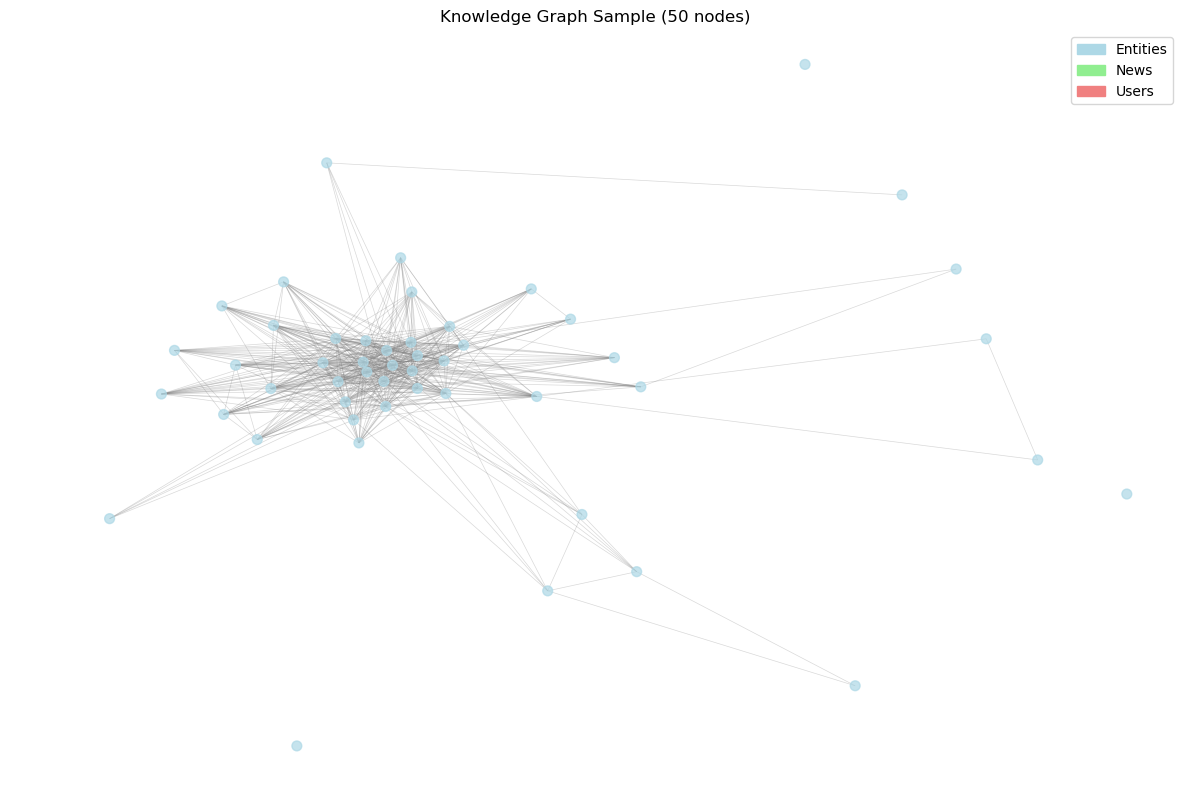

Analysis complete

 Quick Insights:
  • Average connections per node: 116.66
  • Most connected entities are likely popular/important topics
  • Graph density of 0.000904 indicates sparse connectivity
 Analysis results saved to ../data/processed/kg_analysis.json


In [ ]:
def analyze_knowledge_graph_fast(KG):
    """Optimized knowledge graph analysis - much faster"""
    
    print(" Running fast KG analysis...")
    
    # Basic statistics (fast)
    stats = {
        'nodes': KG.number_of_nodes(),
        'edges': KG.number_of_edges(),
        'density': nx.density(KG)
        
    }
    
    print(" Basic stats computed")
    
    # Node type distribution 
    node_types = defaultdict(int)
    entity_nodes = []
    user_nodes = []
    news_nodes = []
    
    for node, data in KG.nodes(data=True):
        node_type = data.get('node_type', 'unknown')
        node_types[node_type] += 1
        
        # Collect nodes by type 
        if node_type == 'entity':
            entity_nodes.append(node)
        elif node_type == 'user':
            user_nodes.append(node)
        elif node_type == 'news':
            news_nodes.append(node)
    
    print(" Node types analyzed")
    
    # Edge type distribution (fast)
    edge_types = defaultdict(int)
    for u, v, data in KG.edges(data=True):
        edge_type = data.get('edge_type', 'unknown')
        edge_types[edge_type] += 1
    
    print(" Edge types analyzed")
    
    # Top entities by degree 
    print(" Computing entity degrees...")
    entity_degrees = []
    for node in entity_nodes[:min(1000, len(entity_nodes))]:  # Limit to first 1000 entities
        degree = KG.degree(node)
        entity_degrees.append((node, degree))
    
    top_entities = sorted(entity_degrees, key=lambda x: x[1], reverse=True)[:10]
    print(" Top entities computed")
    
    return stats, node_types, edge_types, top_entities

def quick_graph_summary(KG):
    """Super quick graph overview"""
    print(" Quick Graph Summary")
    print("=" * 30)
    print(f"Total Nodes: {KG.number_of_nodes():,}")
    print(f"Total Edges: {KG.number_of_edges():,}")
    
    # Sample a few nodes to check structure
    sample_nodes = list(KG.nodes(data=True))[:5]
    print(f"\nSample Nodes:")
    for node, data in sample_nodes:
        print(f"  {node}: {data.get('node_type', 'unknown')} - {data.get('label', 'no label')[:30]}")

def analyze_by_components(KG):
    """Analyze each component separately for better performance"""
    
    # Separate analysis by node type
    entity_subgraph = KG.subgraph([n for n, d in KG.nodes(data=True) if d.get('node_type') == 'entity'])
    news_subgraph = KG.subgraph([n for n, d in KG.nodes(data=True) if d.get('node_type') == 'news'])
    user_subgraph = KG.subgraph([n for n, d in KG.nodes(data=True) if d.get('node_type') == 'user'])
    
    print(" Component Analysis:")
    print(f"Entity Component: {entity_subgraph.number_of_nodes()} nodes, {entity_subgraph.number_of_edges()} edges")
    print(f"News Component: {news_subgraph.number_of_nodes()} nodes, {news_subgraph.number_of_edges()} edges")
    print(f"User Component: {user_subgraph.number_of_nodes()} nodes, {user_subgraph.number_of_edges()} edges")
    
    return entity_subgraph, news_subgraph, user_subgraph

def visualize_graph_sample(KG, max_nodes=100):
    """Visualize a small sample of the graph"""
    
    # Get a small sample
    sample_nodes = list(KG.nodes())[:max_nodes]
    sample_graph = KG.subgraph(sample_nodes)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Get node colors by type
    node_colors = []
    for node in sample_graph.nodes():
        node_type = KG.nodes[node].get('node_type', 'unknown')
        if node_type == 'entity':
            node_colors.append('lightblue')
        elif node_type == 'news':
            node_colors.append('lightgreen') 
        elif node_type == 'user':
            node_colors.append('lightcoral')
        else:
            node_colors.append('lightgray')
    
    # Draw graph
    pos = nx.spring_layout(sample_graph, k=1, iterations=50)
    nx.draw_networkx_nodes(sample_graph, pos, node_color=node_colors, node_size=50, alpha=0.7)
    nx.draw_networkx_edges(sample_graph, pos, alpha=0.3, edge_color='gray', width=0.5)
    
    plt.title(f"Knowledge Graph Sample ({max_nodes} nodes)")
    plt.axis('off')
    
    # Add legend
    import matplotlib.patches as mpatches
    entity_patch = mpatches.Patch(color='lightblue', label='Entities')
    news_patch = mpatches.Patch(color='lightgreen', label='News')
    user_patch = mpatches.Patch(color='lightcoral', label='Users')
    plt.legend(handles=[entity_patch, news_patch, user_patch])
    
    plt.tight_layout()
    plt.show()

# Use the optimized functions
print(" Starting  KG analysis...")

# Quick overview first
quick_graph_summary(KG)

# Fast analysis
stats, node_types, edge_types, top_entities = analyze_knowledge_graph_fast(KG)

print("\n Knowledge Graph Analysis Results:")
print("=" * 40)
print(f"Basic Stats: {stats}")
print(f"Node Types: {dict(node_types)}")
print(f"Edge Types: {dict(edge_types)}")

print(f"\n Top 10 Entities by Degree:")
for entity, degree in top_entities:
    label = KG.nodes[entity].get('label', entity)[:30]  # Truncate long labels
    entity_type = KG.nodes[entity].get('entity_type', 'unknown')
    print(f"  {label} ({entity_type}): {degree} connections")

# Component analysis
print(f"\n Analyzing components...")
entity_subgraph, news_subgraph, user_subgraph = analyze_by_components(KG)

# Visualize small sample
print(f"\n Creating visualization...")
visualize_graph_sample(KG, max_nodes=50)  # Very small sample for speed

print("Analysis complete")

# Additional quick insights
print(f"\n Quick Insights:")
print(f"  • Average connections per node: {KG.number_of_edges() * 2 / KG.number_of_nodes():.2f}")
print(f"  • Most connected entities are likely popular/important topics")
print(f"  • Graph density of {stats['density']:.6f} indicates {'sparse' if stats['density'] < 0.01 else 'dense'} connectivity")


# Create processed directory if it doesn't exist
import os
os.makedirs('../data/processed', exist_ok=True)

# Save analysis results
analysis_results = {
    'stats': stats,
    'node_types': dict(node_types),
    'edge_types': dict(edge_types),
    'top_entities': [(entity, degree, KG.nodes[entity].get('label', '')) for entity, degree in top_entities]
}

# Save to file for later use
import json
try:
    with open('../data/processed/kg_analysis.json', 'w') as f:
        json.dump(analysis_results, f, indent=2)
    print(f" Analysis results saved to ../data/processed/kg_analysis.json")
except Exception as e:
    print(f" Could not save analysis: {e}")
    print(" Analysis results available in memory as 'analysis_results'")